# The Street View House Numbers (SVHN) Dataset

- http://ufldl.stanford.edu/housenumbers/


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from IPython import display

import os
import time
import numpy as np
from scipy.io import loadmat

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import MultiStepLR, StepLR
from torch.utils.data import DataLoader, TensorDataset
from torch.autograd import Variable

import torchsample as ts
from torchvision import datasets, transforms, models

from lib.pytorch_utils import DeepNetTrainer

use_gpu = torch.cuda.is_available()
print('GPU available:', use_gpu)

GPU available: True


In [2]:
train_trafo = transforms.Compose([
    transforms.RandomCrop(30),
    transforms.ToTensor(),
])
valid_trafo = transforms.Compose([
    transforms.CenterCrop(30),
    transforms.ToTensor(),
])

train_ds = datasets.SVHN('/data/datasets/Google_SVHN_2/', split='train', 
                         transform=train_trafo, 
                         target_transform=lambda x: x.astype(np.int)[0] % 10)

valid_ds = datasets.SVHN('/data/datasets/Google_SVHN_2/', split='test', 
                         transform=valid_trafo, 
                         target_transform=lambda x: x.astype(np.int)[0] % 10)

2 torch.Size([3, 30, 30])


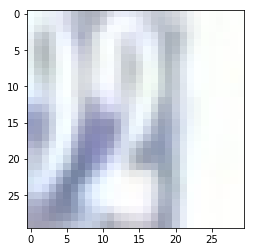

In [3]:
ii = np.random.randint(len(train_ds))
image, label = train_ds[ii]
print(label, image.shape)
plt.imshow(image.numpy().transpose(1, 2, 0));

In [4]:
batch_size = 20
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size, shuffle=False)

In [5]:
class MyCallback(object):
    def __init__(self, interval=1):
        self.interval = interval
    
    def on_train_begin(self, trainer, has_validation=False):
        self.val = has_validation
        self.line_train = None
        self.line_valid = None
        
        self.fig = plt.figure(figsize=(15,6))
        self.ax = self.fig.add_subplot(1, 1, 1)
        self.ax.grid(True)
        self.plot_losses(trainer.metrics['train']['losses'], 
                         trainer.metrics['valid']['losses'])
    
    def on_epoch_end(self, trainer, epoch, best_epoch, t0):
        display.clear_output(wait=True)
        print('n epochs:', len(trainer.metrics['train']['losses']))
        for i in range(len(trainer.metrics['train']['losses'])):
            trainer.print_losses(i)
        if epoch % self.interval == 0:
            self.plot_losses(trainer.metrics['train']['losses'],
                             trainer.metrics['valid']['losses'], best_epoch==epoch)
        
    def plot_losses(self, htrain, hvalid, best_epoch=0):
        if self.line_train: self.line_train.remove()
        if self.line_valid: self.line_valid.remove()
        
        x = np.arange(1, len(htrain) + 1)
        self.line_train, = self.ax.plot(x, htrain, color='#1f77b4', linewidth=2, label='training loss')
        self.line_valid, = self.ax.plot(x, hvalid, color='#ff7f0e', linewidth=2, label='validation loss')
        self.ax.legend()
                
        if best_epoch:
            self.ax.vlines(best_epoch, *(self.ax.get_ylim()), colors='#EBDDE2', linestyles='dashed')

        display.display(self.fig)
        time.sleep(0.1)

    def plot_losses_2(self, htrain, hvalid, best_epoch=0):
        if self.line_train is None:
            line_train = plt.plot(htrain, linewidth=2, label='training loss')
            if hvalid[0]:
                line_valid = plt.plot(hvalid, linewidth=2, label='validation loss')
        else:
            self.line_train.set_xdata(np.arange(htrain.shape[0]))
            self.line_train.set_ydata(htrain)
            if hvalid[0]:
                self.line_valid.set_xdata(np.arange(hvalid.shape[0]))
                self.line_valid.set_ydata(hvalid)
                
        if best_epoch:
            plt.vlines(best_epoch, 0, 100, colors='#EBDDE2', linestyles='dashed')
            
        plt.legend()
        
        display.display(plt.gcf())
        display.clear_output(wait=True)

In [6]:
def compute_accuracy(logits, labels):
    _, preds = torch.max(logits.data, 1)
    return torch.sum(preds == labels.data) / labels.size(0)

In [7]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2, 2)

        self.conv1 = nn.Conv2d(3, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)
        x = x.view(-1, 16 * 4 * 4)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

model = Net()
if use_gpu:
    model.cuda()

In [8]:
trainIt = True

optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = StepLR(optimizer, step_size=5, gamma=0.75)

os.makedirs('../../models', exist_ok=True)
training_parameters = {
    'file_basename': '../../models/svhn_01', 
    'model':         model, 
    'criterion':     nn.CrossEntropyLoss(),
    'metrics':       dict(acc=compute_accuracy), 
    'optimizer':     optimizer, 
    'lr_scheduler':  scheduler, 
    'callbacks':     [MyCallback()],
    'reset':         True,
}

trainer = DeepNetTrainer(**training_parameters)

n epochs: 3
  0:   0.0s   T: 1.05803 0.67603   V: 0.93160 0.73487 best
  1:   0.0s   T: 1.05803 0.67603   V: 0.93160 0.73487 best
  2:   0.0s   T: 1.05803 0.67603   V: 0.93160 0.73487 best


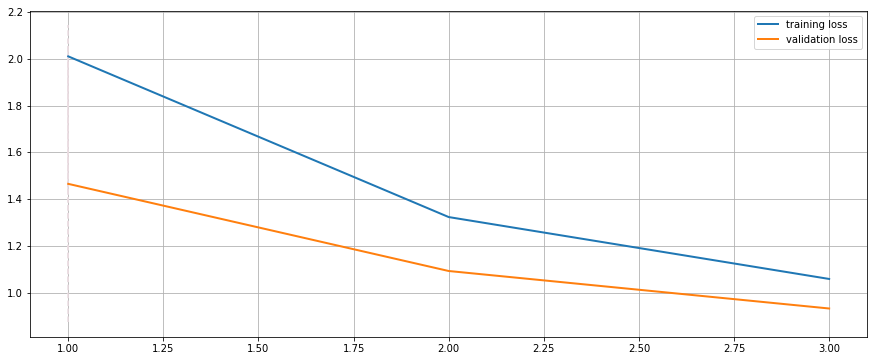


Model from epoch 3 saved as "../../models/svhn_01.*", loss = 0.93160


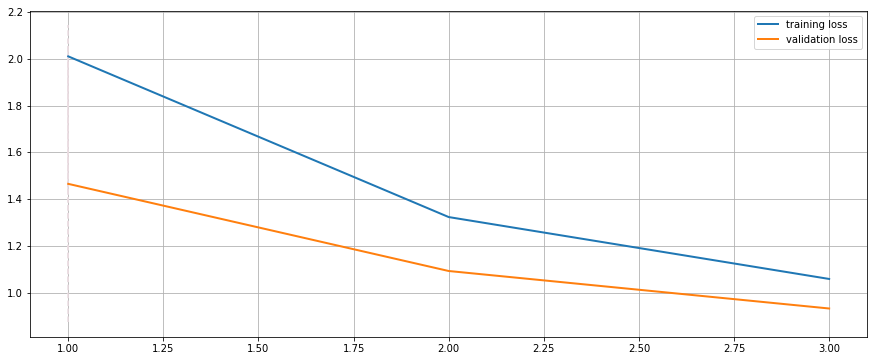

In [9]:
import matplotlib.pyplot as plt

if trainIt:
    trainer.fit(3, train_dl, valid_dl)
else:
    print('\nTraining disabled.\nThis model was trained for {} epochs.'.format(trainer.last_epoch))

In [10]:
trainer = DeepNetTrainer(**training_parameters)

metrics = trainer.evaluate(train_dl)
print('Model training set accuracy after training: {:.5f}'.format(metrics['acc']))
print()
metrics = trainer.evaluate(valid_dl)
print('Model validation set accuracy after training: {:.5f}'.format(metrics['acc']))

evaluate: 3662 ok
Model training set accuracy after training: 0.70496

evaluate: 1301 ok
Model validation set accuracy after training: 0.73487
